In [ ]:
# 필요한 라이브러리 가져오기

import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd
from os import listdir
import cv2
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import imutils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
import requests
from io import BytesIO
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## 주제 : 밭 드론 사진을 통한 작물 종류 판별

### 1. 주제선정 배경
- 농업 분야에서 드론의 역할이 증대되고 있음 
- 이미지 데이터에 대한 흥미

### 2. 자료 출처 : AI HUB 제주 주요작물 자동탐지 데이터 
- 과학기술정보통신부와 한국지능정보사회진흥원의 「지능정보산업 인프라 조성」 사업의 일환으로 구축된 학습용 AI 데이터 제공 사이트
https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=634

### 3. 활용 데이터셋 : 제주도 주요작물 15종의 드론, 항공, 위성 촬영사진
- 20년~22년에 걸쳐 제주 지역에서 촬영한 영상을 가공한 이미지 데이터
- (1단계) 항공, 위성, 드론으로 영상을 촬영 -> (2단계) 영상을 전처리하여 밭 사진 추출 -> (3단계) 라벨링 

<img src='https://drive.google.com/uc?export=download&id=1btbuiVxqGww0nyzM6vsWnbK3DPRUSAGL' width="" height ="" /><br>

- 사진 데이터 예시

<img src='https://drive.google.com/uc?export=download&id=1-8Md1ehGcTq6NSL7sHPv0eSflBcy-tvy' width="" height ="" /><br>

### 4. 데이터 분석
1. 색이 연두색부터 짙은 청록색 등 다양 -> input data를 단색이 아닌 3byte 색상으로 지정이 필요.
ex) input_shape=(150, 150, 3)
2. 작물별 재배방식에 따라 멀칭 유무, 작물 사이 간격 등으로 이미지 특징이 구별될 것으로 예상

### 5. 가설 : 작물별 색상, 잎모양, 재배방식 등 특징을 바탕으로 작물별 이미지 분류가 가능하다 

### 6. 진행과정 : 데이터 전처리 -> 모델학습 -> 평가지표 확인 -> 사진 테스트

## [ 1단계 ] 데이터 전처리

#### 1. 원본 데이터가 4GB가 넘는 관계로 작물 종류별 파일개수를 1000개로 제한하여 샘플데이터 추출

#### 2. 샘플데이터를 ZIP 형태로 구글 드라이브 업로드 후 압축 해제
* 압축해제 후 폴더 형식으로 드라이브 업로드 시 시간 오래 소요됨

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!mkdir dataset_v2/
!unzip /content/drive/MyDrive/개인프로젝트/dataset.zip -d ./dataset_v2

#### 3. 데이터셋을 train data와 validation data로 분리

<img src='https://drive.google.com/uc?export=download&id=1L10S4R7PywR3qPHyZ1l6W8zY9ltsV0D7' width="" height ="" /><br>

<img src='https://drive.google.com/uc?export=download&id=103BAhhllS1mZadi9l3qsz963EKifkJO6' width="" height ="" /><br>


In [ ]:
import os
import numpy as np
import pandas as pd
import shutil
import random

root_dir = '/content/dataset_v2/' # data root path
classes_dir = ['월동무','당근','양배추','마늘','양파','브로콜리','쪽파','콜라비','적채','비트','옥수수','감자','메밀','콩','기장'] #total labels

# 90% , 10% 비율로 데이터를 나눔

data_info = pd.DataFrame(columns=['작물명','total data','train data','validation data'])

val_ratio = 0.1

for cls in classes_dir:
    os.makedirs(root_dir +'train/' + cls)
    os.makedirs(root_dir +'val/' + cls)

    # 파일을 셔플한 뒤 원본 폴더의 이미지 데이터를 train 폴더, validation 폴더로 분리
    src = root_dir + cls 
    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, val_FileNames = np.split(np.array(allFileNames),[int(len(allFileNames)* (1 - val_ratio))])

    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]

    for name in train_FileNames:
        shutil.copy(name, root_dir +'train/' + cls)
    for name in val_FileNames:
        shutil.copy(name, root_dir +'val/' + cls)
    
    crop_data_info = [cls,len(allFileNames),len(train_FileNames),len(val_FileNames)]
    data_info = data_info.append(pd.Series(crop_data_info, index=data_info.columns),ignore_index=True)

<ipython-input-4-bb994f9a1b8f>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_info = data_info.append(pd.Series(crop_data_info, index=data_info.columns),ignore_index=True)
<ipython-input-4-bb994f9a1b8f>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_info = data_info.append(pd.Series(crop_data_info, index=data_info.columns),ignore_index=True)
<ipython-input-4-bb994f9a1b8f>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_info = data_info.append(pd.Series(crop_data_info, index=data_info.columns),ignore_index=True)
<ipython-input-4-bb994f9a1b8f>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_info = data_info.a

In [ ]:
# 작물별 학습 및 검증 데이터
# - 양파, 비트, 옥수수의 데이터가 다른 작물에 비해 개수가 적음

data_info

,작물명,total data,train data,validation data
0,월동무,1000,900,100
1,당근,1000,900,100
2,양배추,1000,900,100
3,마늘,1000,900,100
4,양파,139,125,14
5,브로콜리,1000,900,100
6,쪽파,1000,900,100
7,콜라비,1000,900,100
8,적채,676,608,68
9,비트,185,166,19


/content/dataset_v2/기장/20210709_09801287_20_15_0048.jpg


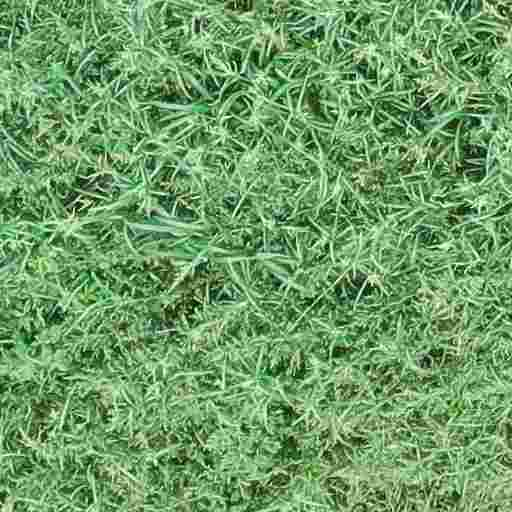

In [ ]:
# 저장된 이미지 확인

import os
import glob
import cv2
from google.colab.patches import cv2_imshow

print(train_FileNames[1])
images = train_FileNames[1] # '기장' 작물의 임의의 이미지 파일
image = cv2.imread(images)
cv2_imshow(image)

## [ 2단계 ] CNN 모델 학습

### CNN(합성곱 신경망, Convolutional Neural Network)
- 이미지, 음성 등의 신호 데이터 처리에 효과적으로 사용되는 딥러닝 모델 중 하나
- 합성곱과 풀링 연산을 여러 층으로 쌓아 올린 구조로 이루어져 있음
- 이렇게 쌓인 층에서 각각의 특징을 추출하여 해당 특징을 바탕으로 이미지를 분류

In [ ]:
import tensorflow as tf
!pip install keras_preprocessing
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.3 MB/s eta 0:00:00


### - train data를 모델에 학습시키기 위해 사이즈 조정 등의 전처리 진행

In [ ]:
root_dir = '/content/dataset_v2/' # data root path
train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')

train_datagen = ImageDataGenerator(rescale = 1./255)
validation_datagen = ImageDataGenerator(rescale = 1./255)

# input 데이터를 150*150 사이즈로 변환
# 따라서 모델에 테스트 하기 위해 사진을 넣어볼 땐 사이즈 조정을 해주어야 한다

train_generator = train_datagen.flow_from_directory(
	train_dir,
	target_size=(150,150),
	class_mode='categorical',                
  batch_size=126) # 모델이 학습하는 동안에 입력 데이터를 몇 개씩 처리할지를 결정

validation_generator = validation_datagen.flow_from_directory(
	val_dir,
	target_size=(150,150),
	class_mode='categorical',            
  batch_size=126)

Found 11096 images belonging to 15 classes.
Found 1235 images belonging to 15 classes.


### CNN 모델 학습

#### * 첫번째 모델 학습 
- 3개의 합성곱 레이어로 구성된 모델을 20번 반복 학습
- 학습데이터의 정확도는 78.95%, 검증데이터의 정확도는 59.6%

#### * 두번째 모델 학습
- 기존 학습데이터를 다양한 형태로 변형시켜 (회전, 비틀림, 확대, 축소 등) 데이터를 풍부하게 만든 뒤 같은 모델로 40회 재학습 진행
- 학습데이터의 정확도는 73.8%, 검증데이터의 정확도는 53.6%


In [ ]:
# https://davinci-ai.tistory.com/29

model = tf.keras.models.Sequential([
    # 3 bytes color의 150&150 사진 데이터를 input
    # 1번째 합성곱 레이어
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # 2번째 합성곱 레이어
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # 3번째 합성곱 레이어
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # 플레튼 레이어
    tf.keras.layers.Flatten(),
    # 64 neuron hidden layer
    tf.keras.layers.Dense(64, activation='relu'),
    # 2가지 이상 분류(15가지) 방법이기 때문에 relu가 아닌 softmax 활성 함수 사용. 최종 dense는 작물종류인 15
    tf.keras.layers.Dense(15, activation='softmax')])

model.summary()
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy']) 
history = model.fit(train_generator, epochs=20, validation_data = validation_generator,verbose = 1)

model.save("/content/drive/MyDrive/개인프로젝트/crop_cls_model_v2.h5")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [ ]:
from keras.models import load_model
model = load_model("/content/drive/MyDrive/개인프로젝트/crop_cls_model_v2.h5")

# 정면 사진을 다양한 형태로 변형시켜 데이터를 풍부하게 만듦 (회전, 비틀림, 확대, 축소 등)
training_datagen_v2 = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_generator_v2 = training_datagen_v2.flow_from_directory(
	train_dir,
	target_size=(150,150),
	class_mode='categorical',                
  batch_size=126)

history = model.fit(train_generator_v2, epochs=20, validation_data = validation_generator, verbose = 1)
model.save("/content/drive/MyDrive/개인프로젝트/crop_cls_model_v3.h5")

model = load_model("/content/drive/MyDrive/개인프로젝트/crop_cls_model_v3.h5")
history = model.fit(train_generator_v2, epochs=20, validation_data = validation_generator, verbose = 1)
model.save("/content/drive/MyDrive/개인프로젝트/crop_cls_model_v4.h5")

Epoch 1/20
89/89 [==============================] - 112s 1s/step - loss: 0.8567 - accuracy: 0.6976 - val_loss: 1.6826 - val_accuracy: 0.5393
Epoch 2/20
89/89 [==============================] - 110s 1s/step - loss: 0.8452 - accuracy: 0.7031 - val_loss: 1.7486 - val_accuracy: 0.5352
Epoch 3/20
89/89 [==============================] - 111s 1s/step - loss: 0.8496 - accuracy: 0.7024 - val_loss: 1.7957 - val_accuracy: 0.5377
Epoch 4/20
89/89 [==============================] - 109s 1s/step - loss: 0.8379 - accuracy: 0.7024 - val_loss: 1.6127 - val_accuracy: 0.5352
Epoch 5/20
89/89 [==============================] - 110s 1s/step - loss: 0.8295 - accuracy: 0.7054 - val_loss: 2.0001 - val_accuracy: 0.5028
Epoch 6/20
89/89 [==============================] - 110s 1s/step - loss: 0.8220 - accuracy: 0.7127 - val_loss: 1.6815 - val_accuracy: 0.5425
Epoch 7/20
89/89 [==============================] - 109s 1s/step - loss: 0.8101 - accuracy: 0.7140 - val_loss: 2.0533 - val_accuracy: 0.4826
Epoch 8/20
89

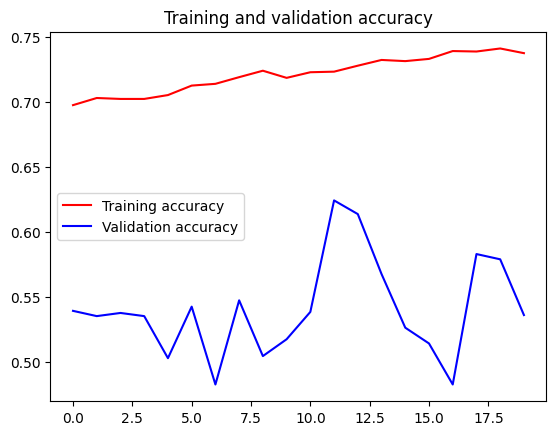

<Figure size 640x480 with 0 Axes>

In [ ]:
# 모델의 Loss와 Accuracy 확인
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

## [3단계] 모델 검증 - 신규 이미지 입력 및 분류 테스트
- 인터넷 뉴스의 밭 이미지를 모델에 입력 \
(ex1) [제주일보 - 메밀밭 주변 산책](https://www.jejunews.com/news/articleView.html?idxno=2193572) \
(ex2) [제주일보 - 당근밭 검질 매기 한창](http://www.jejunews.com/news/articleView.html?idxno=2197019) \
(ex3) [오마이뉴스 - 광활한 옥수수밭](https://www.ohmynews.com/NWS_Web/View/img_pg.aspx?CNTN_CD=IE002192692)

In [ ]:
# 학습된 모델 불러오기

from keras.models import load_model
model = load_model("/content/drive/MyDrive/개인프로젝트/crop_cls_model_v4.h5")

In [ ]:
import requests
from io import BytesIO
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def test_img(url):
  response = requests.get(url)
  img = load_img(BytesIO(response.content), target_size=(150, 150))
  plt.imshow(img)
  plt.show()

  img = img_to_array(img)
  img = img / 255.0
  img = np.expand_dims(img, axis=0)

  # Make a prediction
  prediction = model.predict(img)

  # Interpret the prediction
  predicted_class = np.argmax(prediction)
  class_names = ['월동무','당근','양배추','마늘','양파','브로콜리','쪽파','콜라비','적채','비트','옥수수','감자','메밀','콩','기장'] #total labels
  print('이 밭의 작물은 : "', class_names[predicted_class], '" 으로 예측됩니다.')





------------------------------------------------------메밀밭---------------------------------------------




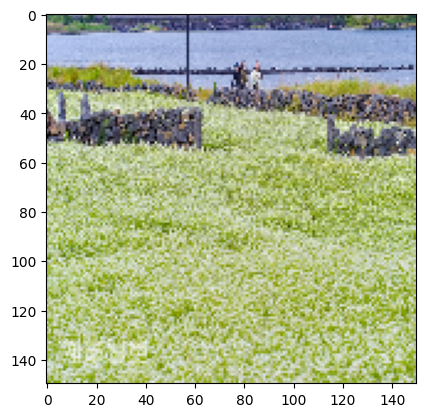

1/1 [==============================] - 0s 26ms/step
이 밭의 작물은 : " 메밀 " 으로 예측됩니다.


------------------------------------------------------당근밭---------------------------------------------




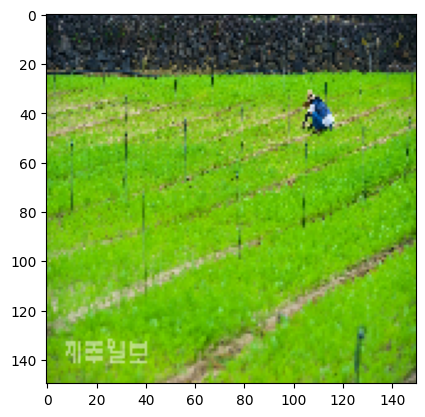

1/1 [==============================] - 0s 26ms/step
이 밭의 작물은 : " 당근 " 으로 예측됩니다.


-----------------------------------------------------옥수수밭---------------------------------------------




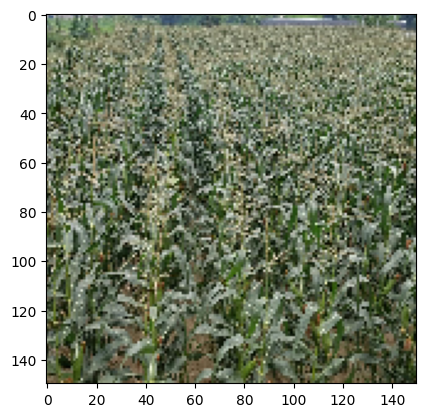

1/1 [==============================] - 0s 27ms/step
이 밭의 작물은 : " 콩 " 으로 예측됩니다.


In [ ]:
print("\n\n------------------------------------------------------메밀밭---------------------------------------------\n\n")
url_maemil = "https://www.jejunews.com/news/photo/202206/2193572_216590_020.jpg"
test_img(url_maemil)

print("\n\n------------------------------------------------------당근밭---------------------------------------------\n\n")

url_carrot = "http://www.jejunews.com/news/photo/202210/2197019_220564_1931.jpg"
test_img(url_carrot)

print("\n\n-----------------------------------------------------옥수수밭---------------------------------------------\n\n")

url_corn = "https://ojsfile.ohmynews.com/PHT_IMG_FILE/2017/0722/IE002192692_PHT.jpg"
test_img(url_corn)

## 결과 및 느낀점

- 데이터 전처리 과정의 어려움
> 대용량 이미지를 업로드하고, 불러오는 과정 등

- 여러 방법을 시도 하였으나 모델의 정확도가 낮음
> 학습데이터를 회전, 길이 및 폭 조정, 줌 등으로 다양화 해서 학습하였지만 정확도가 별 차이 없음

- 데이터 양을 늘리고, 학습 횟수를 더 많이 했었다면 더 정확도가 높아지지 않았을까 하는 아쉬움